# Finding a detection strategy
It is necesary to obtain the bounding box of the faces present for every frame on all videos. The GPU-backed face detector allows to efficiently process many frames in parallel. Despite this, running the face detector for all frames adds up to a considerable time. Addtionally, the face detector is agnostic to previous results leading to undesirable gaps and jittering. A gap is a short secuence of frames where the face remains undetected before suddenly returning, while jittering presents itself when succesive high-frequency detections result in bounding box coordinates that sharply oscillate.

The number of frames to be processed by the face detector and their dimensions affect the duration of a detection operation. An intuitive solution is to reduce both of them as reducing the amount of data being transfered between GPU and principal memories the operation can be sped-up. The *speedup* factor stands for the relative decrease in time spent detecting and its given by the ratio between the video length and the time spent processing it.

Lowering the detection frame rate can mitigate the jittering while introducing regular periodic gaps on the bounding box sequence. These gaps can be filled with values that soften the transition between detected points. An interpolation estrategy can be selected to fill missing data while keeping this transition as smooth as possible. The tried estrategies correspond the implementations of spline interpolators for zeroth, first, second and third order, that are already available on the *Python* library *SciPy*.

To maintain a reference based on actual data, the high frequency samples require an smoothing operation. This low-pass filter takes the form of a moving window averaging past detections. The window sequence contributions can be adjusted by the relative temporal distance to the sampled item. Three smoothing operations were tested: Uniform weights, Inversely linear weights and Gaussian weights. From these the one with the lowest MSE was chosen. The smoothed sequence was used as reference as it is the closest to an ideal result.

> The weights for a window of size $n$ on a sequence of length $m$ are computed as follows for Uniform weights ($W^U$), Inversely linear weights ($W^L$) and Gaussian weights ($W^G$).
> 
> $\forall i \in [0, m]$ $\forall j \in [0, n]$
> 
> $W^U_{ij}=1$
> 
> $W^L_{ij}=\frac{1}{|t_{i-j}-t_i| + 1}$
> 
> $W^G_{ij}=\frac{1}{P \sqrt{2 \pi}} e^{-\frac{1}{2}(\frac{t_{i-j}-t_i}{P})^2}$
> 
> The weights are normalized by the total sum of the weights. Notice that $W^G$ corresponds to the Gaussian distribution which mean is at instant $t_i$ and a deviation of $P=\frac{1}{f_r}$ with $fr$ being the frame rate. With this configuration $t_{i-j} = t_i - (j \times P)$ quickly approaches zero.

To find the speedup factors a random sample of 150 videos was selected to be run through the face detector with a frame rate of 30, 15, 6, and 3 FPS. To acomodate batches of 1024 frames, all videos were resized by a factor of 8 due to harware restraints. The found bounding boxes for the 30 FPS videos were selected to further analyse the interpolation and smoothing experiments as this frame rate is the maximum allowed value by the the acquired videos. From these results 5000 random samples of 5 seconds were extracted from a total of 3846 tracks.

## Questions
> + Does lowering the frame rate make an improovement on detection time?
    + By how much?
    + Thresholding the frame size to a maximum value may help too, what dimensions to use as threshold?
> + Averaging past detections decrease the jittering?
    + Which performs the best?
> + Which interpolation strategy is closer to the true detection?
    + Which is closer to the softened detection?

In [1]:
VIDEO_LENGTH_FILE = r'../data/video_length.csv'
TRACK_LENGTH_FILE = r'../data/track_length.csv'
TRACK_POINTS_FILE = r'../data/video_points.pkl'
TRACK_FOLDERS = {
    30: r'../data/test_tracks@30FPS',
    15: r'../data/test_tracks@15FPS',
    6: r'../data/test_tracks@6FPS',
    3: r'../data/test_tracks@3FPS',
}
REFERENCE_FRAME_RATE = 30
SAMPLE_LENGTH = 5.0
SAMPLE_NUM = 5000

In [2]:
%matplotlib inline
import json
import pickle
from datetime import timedelta
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.interpolate import interp1d

In [3]:
def load_length_data(track_folders):
    video_data = []
    track_data = []
    
    for fps, path in track_folders.items():
        for track_file in Path(path).glob('**/*.tracks.json'):
            with track_file.open('r', encoding='utf8') as fp:
                track_file = json.load(fp)
            
            # Video lengths
            video_data.append([track_file['video_duration'],
                               track_file['detection_duration'],
                               track_file['width'],
                               track_file['height'],
                               fps])

            # Track lengths
            for track in track_file['tracks'].values():
                track_data.append([track['time'][-1] - track['time'][0],
                                   track_file['width'],
                                   track_file['height'],
                                   fps])
    return video_data, track_data

In [4]:
def load_point_data(track_folder):
    data_time = []
    data_bbox = []
    data_tlen = []

    for track_file in Path(track_folder).glob('**/*.tracks.json'):
        with track_file.open('r', encoding='utf8') as fp:
            track_file = json.load(fp)

        # Ignore videos without tracks
        if len(track_file['tracks']) == 0:
            continue

        track_time, track_bbox = zip(*[(t['time'], t['bbox']) for t in track_file['tracks'].values()])

        track_time = list(track_time)
        track_bbox = list(track_bbox)
        track_tlen = []

        for i, (t, b) in enumerate(zip(track_time, track_bbox)):        
            # All tracks start from 0
            t = np.float32(t) - t[0]
            track_time[i] = t.tolist()

            # Length of a track in seconds
            track_tlen.append(t[-1])

            # Box positions from screen center
            b = np.float32(b).reshape(-1, 2, 2)
            b[:, :, 0] -= 0.5 * track_file['width']
            b[:, :, 1] -= 0.5 * track_file['height']
            track_bbox[i] = b.tolist()

        data_time.extend(track_time)
        data_bbox.extend(track_bbox)
        data_tlen.extend(track_tlen)
    return data_time, data_bbox, data_tlen

In [5]:
video_data_src = Path(VIDEO_LENGTH_FILE)
track_data_src = Path(TRACK_LENGTH_FILE)
point_data_src = Path(TRACK_POINTS_FILE)

video_data_columns = [('video_length', float),
                      ('time_detecting', float),
                      ('width', int),
                      ('height', int),
                      ('fps', int)]
track_data_columns = [('track_length', float),
                      ('width', int),
                      ('height', int),
                      ('fps', int)]

In [6]:
# Load video data
if video_data_src.exists() and track_data_src.exists:
    video_df = pd.read_csv(video_data_src, index_col=0, dtype=dict(video_data_columns))
    track_df = pd.read_csv(track_data_src, index_col=0, dtype=dict(track_data_columns))
else:
    video_data, track_data = load_length_data(TRACK_FOLDERS)
    
    video_df = pd.DataFrame.from_records(video_data, columns=[n for n, t in video_data_columns])
    track_df = pd.DataFrame.from_records(track_data, columns=[n for n, t in track_data_columns])
    
    video_df.to_csv(video_data_src)
    track_df.to_csv(track_data_src)

In [7]:
# Load track data
if point_data_src.exists():
    with point_data_src.open('rb') as fp:
        data_time, data_bbox, data_tlen = pickle.load(fp)
else:
    data_time, data_bbox, data_tlen = load_point_data(TRACK_FOLDERS[REFERENCE_FRAME_RATE])
    
    with point_data_src.open('wb') as fp:
        pickle.dump((data_time, data_bbox, data_tlen), fp, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
print('Number of tracks:', len(data_time))

Number of tracks: 3846


In [9]:
# Sampling tracks
np.random.seed(0)

# Pick random track and a random position to start a slice
track_samples = (np.random.random(SAMPLE_NUM) * len(data_time)).astype(int)
track_start = np.random.random(SAMPLE_NUM) * (np.float32(data_tlen)[track_samples] - SAMPLE_LENGTH)

test_time = []
test_bbox = []

for ti, ts in zip(track_samples, track_start):
    t_time = []
    t_bbox = []
    # Add the frames that lie between the picked slice bounds
    for i in range(len(data_time[ti])):
        if ts <= data_time[ti][i] < ts + SAMPLE_LENGTH:
            t_time.append(data_time[ti][i])
            t_bbox.append(data_bbox[ti][i])
    # Make slices start from 0
    test_time.append(np.float32(t_time) - t_time[0])
    test_bbox.append(np.float32(t_bbox))

# Results

In [10]:
video_df['area'] = video_df['width'] * video_df['height']
video_df['speedup'] = video_df['video_length'] / video_df['time_detecting']

df = video_df.groupby(['area', 'fps']).agg([np.mean, np.std]).reset_index(level='area')

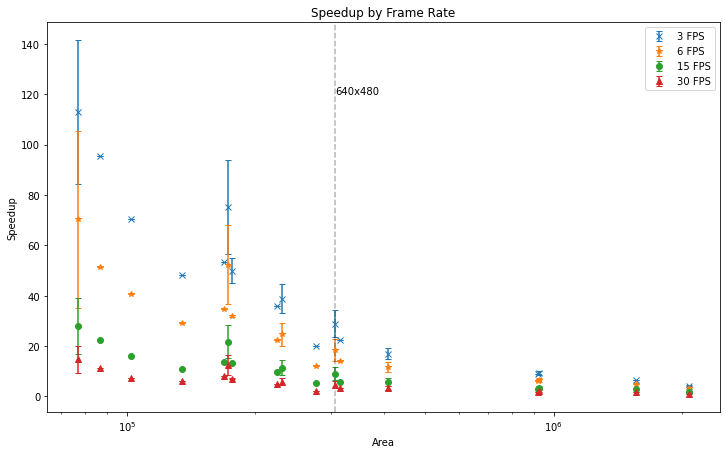

In [11]:
# Speedup as affected by area and frame rate.
# The vertical line is the selected threshold resolution that covers 75% of the dataset

fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
markers='x*o^'

for marker, (key, group) in zip(markers, df.groupby('fps')):
    yerr = group[('speedup', 'std')].fillna(0)
    ax.errorbar(group['area'], group[('speedup', 'mean')], yerr=yerr, capsize=3, fmt=marker, label=f'{key} FPS')

# ax.set_yscale('log')
ax.set_xscale('log')
    
# 640 x 480
plt.axvline(x=640*480, color='#0f0f0f50', linestyle='--')
plt.text(640*480, 120, "640x480")
    
fig.tight_layout()
plt.title('Speedup by Frame Rate')
plt.xlabel('Area')
plt.ylabel('Speedup')
plt.legend()
plt.show()

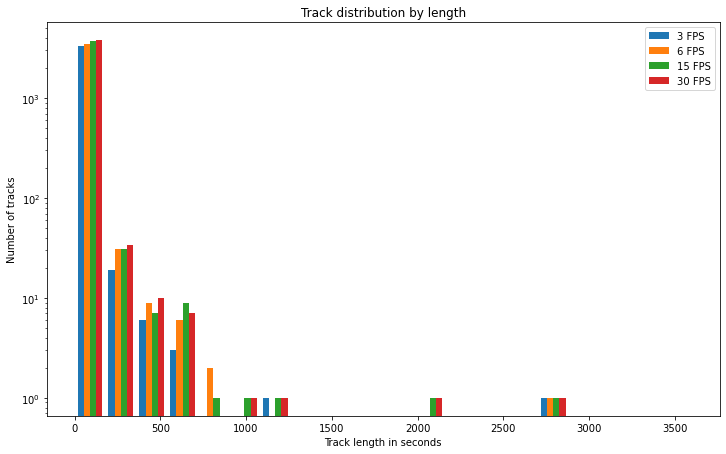

In [12]:
# Track distribution by duration, color by framerate
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

labels, track_lengths = zip(*[(f'{key} FPS', group['track_length']) for key, group in track_df.groupby('fps')])
ax.hist(track_lengths, bins=20, label=labels, range=(0, 3600))
ax.set_yscale('log')

fig.tight_layout()
plt.title('Track distribution by length')
plt.xlabel('Track length in seconds')
plt.ylabel('Number of tracks')
plt.legend()
plt.show()

In [13]:
def gaussian(x, mu, sigma):
    return (1.0 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu)**2) / (2 * sigma**2))

def soften(x, y, win_size, fn):
    soft_y = []
    for c in range(len(x)):
        istart = max(c - win_size, 0)
        iend = c + 1
        # iend = min(c + win_size, len(x)-1)
        weights = fn(x[istart:iend])
        weights = weights / np.sum(weights)
        soft_y.append(np.average(y[istart:iend], weights=weights, axis=0))
    return np.float32(soft_y)

def mse(x_t, x_p, axis=None):
    t_area = np.mean(x_t, axis=0)
    t_area = (t_area[1, 0] - t_area[0, 0]) * (t_area[1, 1] - t_area[0, 1])
    return np.mean((x_t - x_p)**2) / t_area

def get_center_area(bbox):
    cter = np.sqrt(np.sum((0.5 * np.sum(bbox, axis=1))**2, axis=-1))
    area = (bbox[:, 1, 0] - bbox[:, 0, 0]) * (bbox[:, 1, 1] - bbox[:, 0, 1])
    cter = cter - np.mean(cter)
    area = area - np.mean(area)
    return cter, area

def get_error(ldiff):
    udiff = -ldiff
    ldiff[ldiff < 0] = 0
    udiff[udiff < 0] = 0
    return (ldiff, udiff)

def select_times(in_times, in_period, out_period):
    out_times = np.round(in_times / in_period).astype(int)
    k = int(np.round(out_period / in_period))
    out_times = np.mod(out_times, k)
    return np.argwhere(out_times == 0)

In [14]:
# Find the softnening strategy with the lowest error.
test_cases = {
    'Uniform': lambda x: np.ones_like(x),
    'Linear': lambda x: 1.0 / (np.abs(x - x[-1]) + 1.0),
    'Gaussian': lambda x: gaussian(x, x[-1], 1.0 / REFERENCE_FRAME_RATE),
}

soft_bbox = {k: [] for k in test_cases}
mse_errors = {k: [] for k in test_cases}

for label, op in test_cases.items():
    for true_time, true_bbox in zip(test_time, test_bbox): 
        soft_bbox[label].append(soften(true_time, true_bbox, 5, op))
        
        mse_err = mse(true_bbox, soft_bbox[label][-1])
        mse_errors[label].append(mse_err)

In [15]:
table = ((label, mse_err) for label, mse_errs in mse_errors.items() for mse_err in mse_errs)
df = pd.DataFrame(table, columns=['weight_type', 'mse'])
df.head()

,weight_type,mse
0,Uniform,0.000882
1,Uniform,0.000679
2,Uniform,0.001049
3,Uniform,0.000924
4,Uniform,0.002297


Min Error	Uniform 9.817992e-09
Min Error	Linear 9.244097e-09
Min Error	Gaussian 1.2070318e-09
Med Error	Uniform 0.0014348199
Med Error	Linear 0.0013499401
Med Error	Gaussian 0.00018968877
Max Error	Uniform 0.02072026
Max Error	Linear 0.019277573
Max Error	Gaussian 0.0011649247


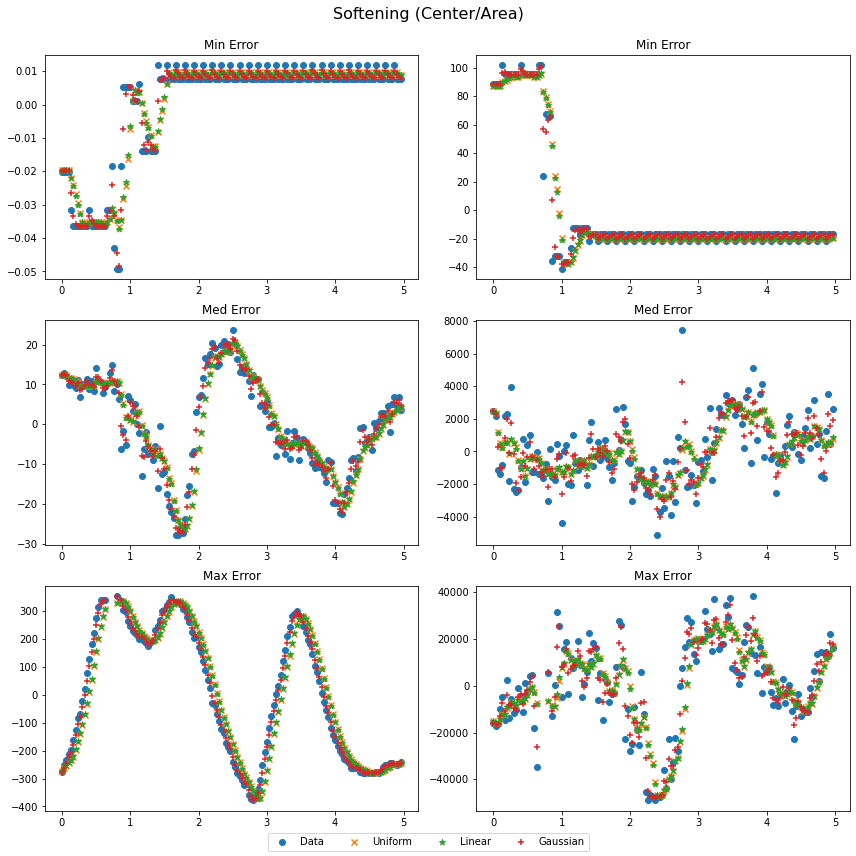

In [16]:
example_idx = {
    'Min Error': np.argmin(mse_errors['Gaussian']),
    'Med Error': np.argsort(mse_errors['Gaussian'])[len(mse_errors['Gaussian'])//2],
    'Max Error': np.argmax(mse_errors['Gaussian']),
}

fig, axs = plt.subplots(nrows=len(example_idx),
                        ncols=2,
                        figsize=(4*len(example_idx), 12),
                        constrained_layout=True,
                        squeeze=False)

line_labels = {}
for i, (name, eidx) in enumerate(example_idx.items()):
    cter_ax = axs[i, 0]
    area_ax = axs[i, 1]
    
    true_time = test_time[eidx]
    true_bbox = test_bbox[eidx]

    true_cter, true_area = get_center_area(true_bbox)
    l = cter_ax.scatter(true_time, true_cter, marker='o', label='Data')
    l = area_ax.scatter(true_time, true_area, marker='o', label='Data')
    line_labels['Data'] = l

    for (label, op), m in zip(test_cases.items(), 'x*+'):
        soft_cter, soft_area = get_center_area(soft_bbox[label][eidx])
        mse_err = mse_errors[label][eidx]
        
        print(name + '\t' + label, mse_err)
        
        l = cter_ax.scatter(true_time, soft_cter, marker=m)
        l = area_ax.scatter(true_time, soft_area, marker=m)
        line_labels[label] = l

    cter_ax.set_title(name)
    area_ax.set_title(name)

labels, lines = zip(*line_labels.items())

fig.set_constrained_layout(False)
plt.tight_layout()

fig.suptitle('Effect of smoothing on BBox Center and Area', fontsize=16)
fig.legend(lines, labels, loc=('lower center'), ncol=len(labels))    
fig.subplots_adjust(bottom=0.05, top=0.925)
plt.show()

In [17]:
interp_type = ['zero', 'slinear', 'quadratic', 'cubic']
frame_rates = [15, 6, 3]
soft_kind = 'Gaussian'

table = []
for true_time, true_bbox, sref_bbox in zip(test_time, test_bbox, soft_bbox[soft_kind]):
    for interp_kind in interp_type:
        for frame_rate in frame_rates:
            idx = select_times(true_time, 1.0 / REFERENCE_FRAME_RATE, 1.0 / frame_rate)
            
            # Create the interpolated model from the subsampled data
            sub_time = true_time[idx].flatten()
            sub_bbox = true_bbox[idx].reshape(-1, 2, 2)
            
            try:
                bbox_inter = interp1d(sub_time,
                                      sub_bbox,
                                      kind=interp_kind,
                                      bounds_error=False,
                                      fill_value='extrapolate',
                                      axis=0)
                fill_bbox = bbox_inter(true_time)
            except ValueError as e:
                fill_bbox = np.zeros_like(true_bbox)
            
            # Compare the interpolated points with the reference ones
            mse_err = mse(sref_bbox, fill_bbox)
            
            table.append((interp_kind, frame_rate, mse_err))

df = pd.DataFrame(table, columns=['interpolation_type', 'frame_rate', 'MSE'])

In [18]:
df.head()

,interpolation_type,frame_rate,MSE
0,zero,15,0.000157
1,zero,6,0.001209
2,zero,3,0.002652
3,slinear,15,0.000169
4,slinear,6,0.000426


In [19]:
df.describe()

,frame_rate,MSE
count,60000.000000,6.000000e+04
mean,8.000000,3.750188e-02
std,5.099062,4.151309e+00
min,3.000000,1.526307e-09
25%,3.000000,3.559438e-04
50%,6.000000,7.603229e-04
75%,15.000000,1.664188e-03
max,15.000000,9.715062e+02


```python
width = 0.75
hatch_pattern = '\\'

def plot_fig(results, interpolation_kinds, use_log, title):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes()

    positions = np.stack([np.linspace(i - width / 2, i + width/2, len(soft_type) * len(interpolation_kinds))
                          for i in np.arange(len(frame_rates))])
    positions = positions.reshape(len(frame_rates), len(interpolation_kinds), len(soft_type))

    for i, kind in enumerate(interpolation_kinds):
        values = []
        for fr in frame_rates:
            values.extend([results[f'{kind}{is_soft}@{fr}FPS'] for is_soft in soft_type])
        b = ax.bar(positions[:, i].flatten(), values, width / (len(soft_type) * len(interpolation_kinds)), label=kind)
        for k, bb in enumerate(b):
            if k % 2 == 1:
                bb.set_hatch(hatch_pattern)
    if use_log:
        ax.set_yscale('log')
    fig.tight_layout()
    plt.xticks(np.arange(len(frame_rates)), [f'{fr} FPS' for fr in frame_rates])
    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor='w', hatch=hatch_pattern, label='Gaussian Softening'))
    plt.legend(handles=handles)
    plt.title(title)
    plt.show()

plot_fig(mse_results, ['zero', 'slinear', 'quadratic', 'cubic'], True, 'MSE against Detections')
plot_fig(mse_results, ['zero', 'slinear'], False, 'MSE against Detections')
plot_fig(mse_soft_results, ['zero', 'slinear', 'quadratic', 'cubic'], True, 'MSE against Softented Detections')
plot_fig(mse_soft_results, ['zero', 'slinear'], False, 'MSE against Softented Detections')
```

# Apendix: Gauss Smoothing example

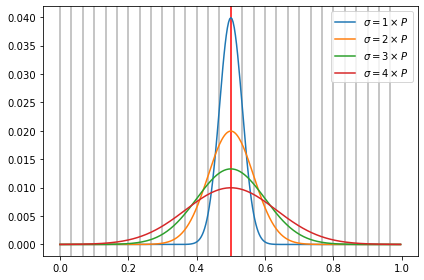

In [20]:
fig = plt.figure()
ax = plt.axes()

# Plot vertical lines
for x in np.arange(0, 1, (1.0 / 30.0)):
    if x == 0.5:
        color = 'red'
    else:
        color = '#0f0f0f50'
    plt.axvline(x=x, color=color)

# Plot gaussian distribution
x = np.arange(0, 1, 1.0 / 300.0)
for i in range(1, 5):
    y = gaussian(x, 0.5, i / 30.0)
    y = y / np.sum(y)
    ax.plot(x, y, label=f'$\sigma={i} \\times P$')
    
fig.tight_layout()
plt.legend()
plt.show()

In [21]:
P = 1.0 / (1.0 / 30.0)
x = np.arange(5) * P
y = gaussian(x, x[-1], P)
y = y / np.sum(y)
print([f'{i:.5f}' for i in y])

['0.00019', '0.00634', '0.07719', '0.34593', '0.57035']
